## Frameworks de alto nivel (PyTorch Lightning)

<a target="_blank" href="https://github.com/pglez82/DeepLearningWeb/blob/master/labs/notebooks/Frameworks%20alto%20nivel%20(PyTorch%20Lightning).ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

PyTorch Lightning es una biblioteca de código abierto diseñada para simplificar y acelerar el proceso de entrenamiento de modelos de aprendizaje profundo utilizando PyTorch. Proporciona una abstracción de alto nivel sobre PyTorch que ayuda a los investigadores y desarrolladores a escribir código más limpio y legible, al tiempo que aprovechan al máximo la flexibilidad y potencia de PyTorch.

Una de las principales ventajas de PyTorch Lightning es su enfoque en la modularidad y la organización del código. Proporciona una estructura clara y consistente para definir modelos, optimizadores, funciones de pérdida y bucles de entrenamiento y validación. Esto facilita la reutilización de código y la experimentación rápida con diferentes arquitecturas y configuraciones de entrenamiento.

Además, PyTorch Lightning se encarga de tareas como la configuración de dispositivos (CPU o GPU), la administración automática de la memoria, el seguimiento de métricas durante el entrenamiento y la gestión de la generación de registros (logs). También incluye características avanzadas, como el entrenamiento distribuido y la integración con bibliotecas populares de visualización y registro.

### Instalación

In [1]:
!pip install lightning
!pip install ipympl # para gráficos interactivos

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Definición de la red
En este caso vamos a entrenar un pequeño **autoencoder** para ejemplificar el uso de PyTorch Lightning. En lugar de utilizar como clase base la clase `torch.nn.Module`, utilizaremos `pl.LightningModule`.

In [2]:
from torch import optim, nn
import lightning.pytorch as pl
import torchmetrics as tm
import torch.nn.functional as F

# Definimos la red
class AutoEncoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(28 * 28, 64), nn.ReLU(), nn.Linear(64, 3))
        self.decoder = nn.Sequential(nn.Linear(3, 64), nn.ReLU(), nn.Linear(64, 28 * 28))
        # Utilizado para aculumar el loss en el bucle de validación
        self.validation_loss = tm.MeanSquaredError()

    # Este método define el bucle de entrenamiento
    def training_step(self, batch, batch_idx):
        #Al ser un autoencoder, no necesitamos la y
        x, _ = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, _ = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.validation_loss(x_hat, x)
        self.log("val_loss", loss, prog_bar=True)

    def on_validation_epoch_end(self):
        val_loss = self.validation_loss.compute()
        self.log("val_loss_epoch", val_loss)

    def predict_step(self, batch, batch_idx):
        x, _ = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        return z

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
model = AutoEncoder()

### Cargamos el Dataset
En este caso utilizaremos la clase que PyTorch Lightning provee para la carga de datos: `pl.LightningDataModule`. Para ello debemos de implementar una serie de métodos que devolverán los DataLoaders correspondientes:

In [3]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import random_split, DataLoader

class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=32, num_workers=2):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transforms.Compose([transforms.ToTensor()])

    def prepare_data(self):
        # descargamos los datos
        MNIST(root='data', train=True, download=True)
        MNIST(root='data', train=False, download=True)

    def setup(self, stage):
        if stage == "fit":
            mnist_full = MNIST(root='data', train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [50000, 10000])
        if stage == "predict":
            self.mnist_test = MNIST(root='data', train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def predict_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

mnist = MNISTDataModule()

### Entrenando el modelo
Para entrenar el modelo solo necesitaremos crear una instancia de la clase `Trainer` y llamar al método `fit`. ESta clase nos ecapsula, entre otras cosas, las siguientes características:


- Bucle de entrenamiento
- Las llamadas `optimizer.step()`, `loss.backward()`, `optimizer.zero_grad()`.
- Las llamadas `model.eval()`, para deshabilitar los gradientes durante la evaluación.
- Carga y salvado de checkpoints.
- Logueo del experimento (usando tensorboard)
- Entrenamiento en múltiples GPUs y TPUs
- Entrenamiento con precisión de 16 bits

In [4]:
trainer = pl.Trainer(max_epochs=5)
trainer.fit(model=model, datamodule=mnist)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/pablo/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(

  | Name            | Type             | Params
-----------------------------------------------------
0 | encoder         | Sequential       | 50.4 K
1 | decoder         | Sequential       | 51.2 K
2 | validation_loss | MeanSquaredError | 0     
---------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

/home/pablo/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/pablo/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [7]:
import torch
latent_space_embeddings = trainer.predict(model, datamodule=mnist)
latent_space_embeddings = torch.concat(latent_space_embeddings, axis=0)

/home/pablo/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

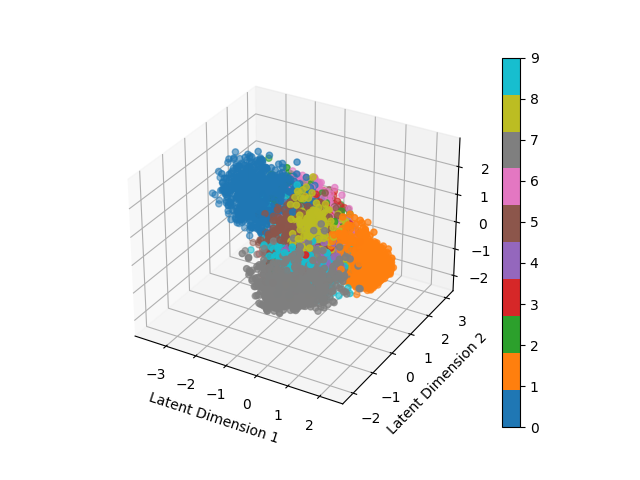

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

# Assuming `latent_space_embeddings` contains the latent space representations
# and `labels` contains the corresponding labels

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the latent space embeddings with color-coded labels
scatter = ax.scatter(
    latent_space_embeddings[:, 0],
    latent_space_embeddings[:, 1],
    latent_space_embeddings[:, 2],
    c=mnist.mnist_test.targets,
    cmap='tab10'
)

# Add a colorbar to show the label colors
plt.colorbar(scatter)

# Set labels for the axes
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')

# Show the plot
plt.show()
